In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Cargamos el dataframe de movies limpio, luego del ETL
movies_aux = pd.read_csv('Dataset/movies_aux.csv', parse_dates = ['release_date'])

In [8]:
# Ordenamos las columnas para darle una mejor representación y eliminamos las que en un principio no vamos a utilizar
# Collection: Son 1695 colecciones, nos daria una gran matriz dispersa. Dificil de manejar en Render
movies_aux = movies_aux.reindex(columns = ["id", "title", "genres", "release_year", "popularity", "vote_average", "vote_count",
                                "production_companies", "production_countries", "runtime", "budget", "revenue"])

In [9]:
movies_aux.head()

,id,title,genres,release_year,popularity,vote_average,vote_count,production_companies,production_countries,runtime,budget,revenue
0,862.0,Toy Story,"['Animation', 'Comedy', 'Family']",1995,21.946943,7.7,5415.0,['Pixar Animation Studios'],['United States of America'],81.0,30000000.0,373554033.0
1,8844.0,Jumanji,"['Adventure', 'Fantasy', 'Family']",1995,17.015539,6.9,2413.0,"['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],104.0,65000000.0,262797249.0
2,15602.0,Grumpier Old Men,"['Romance', 'Comedy']",1995,11.712900,6.5,92.0,"['Warner Bros.', 'Lancaster Gate']",['United States of America'],101.0,0.0,0.0
3,31357.0,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",1995,3.859495,6.1,34.0,['Twentieth Century Fox Film Corporation'],['United States of America'],127.0,16000000.0,81452156.0
4,11862.0,Father of the Bride Part II,['Comedy'],1995,8.387519,5.7,173.0,"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],106.0,0.0,76578911.0


In [10]:
# Conversion para que a cada elemento lo tome como una lista (no string) y poder hacer el encoding
movies_aux["genres"] = movies_aux["genres"].apply(eval).apply(list)
# Creamos la instancia del decoder
mlb_1 = MultiLabelBinarizer()
mlb_1.fit(movies_aux["genres"])
mlb_1.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'Sin_Categoria', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype=object)

In [11]:
# Se aplico correctamente el fit, ahora transformamos la columna y lo cargamos a un df auxiliar
genres_encoded = mlb_1.transform(movies_aux["genres"])
genres_encoded = pd.DataFrame(genres_encoded, columns = mlb_1.classes_)
genres_encoded = genres_encoded.add_prefix("genres_")

In [12]:
# Borramos la columna Sin_categoria.
genres_encoded = genres_encoded.drop(columns = ["genres_Sin_Categoria"])

In [13]:
genres_encoded.sum().sort_values(ascending = False).head(8)

genres_Drama          20255
genres_Comedy         13181
genres_Thriller        7619
genres_Romance         6733
genres_Action          6592
genres_Horror          4670
genres_Crime           4305
genres_Documentary     3921
dtype: int64

In [14]:
# Vemos la distribucion de los generos
# Graficar el gráfico de torta
#plt.pie(genres_encoded, labels = genres_encoded.columns, autopct='%1.1f%%', startangle=90)

In [15]:
# production_companies
movies_aux["production_companies"] = movies_aux["production_companies"].apply(eval).apply(list)     # Conversion para que a cada elemento lo tome como una lista (no string)
# Creamos la instancia del decoder
mlb_3 = MultiLabelBinarizer()
pcomp_encoded = mlb_3.fit_transform(movies_aux["production_companies"])
pcomp_encoded = pd.DataFrame(pcomp_encoded, columns = mlb_3.classes_)
pcomp_encoded = pcomp_encoded.add_prefix("pcomp_")

In [16]:
# Vimos que Columbia Pictures esta en dos columnas distintas, las concatenamos
pcomp_encoded["pcomp_Columbia Pictures Corporation"] = pcomp_encoded["pcomp_Columbia Pictures Corporation"] | pcomp_encoded["pcomp_Columbia Pictures"]
# Borramos la columna Sin_categoria y Columbia_Pictures.
pcomp_encoded = pcomp_encoded.drop(columns = ["pcomp_Sin_Categoria", "pcomp_Columbia Pictures"])

In [17]:
# Tenemos mas de 23 mil productoras y seria muy dificil de manipular. 
pcomp_encoded.shape

(45379, 23533)

In [18]:
# Hacemos un top 80 con las compañias que más peliculas han filmado
top_80_comp = pcomp_encoded.sum().sort_values(ascending = False).head(80).index.tolist()
pcomp_encoded = pcomp_encoded[top_80_comp]

In [19]:
pcomp_encoded.sum().sum()

13776

In [20]:
# production_countries
movies_aux["production_countries"] = movies_aux["production_countries"].apply(eval).apply(list)     # Conversion para que a cada elemento lo tome como una lista (no string)
# Creamos la instancia del decoder
mlb_4 = MultiLabelBinarizer()
pcountries_encoded = mlb_4.fit_transform(movies_aux["production_countries"])
pcountries_encoded = pd.DataFrame(pcountries_encoded, columns = mlb_4.classes_)
pcountries_encoded = pcountries_encoded.add_prefix("pcountries_")

In [21]:
pcountries_encoded.sum().sum()

55625

In [22]:
# Borramos la columna Sin_categoria y Columbia_Pictures.
pcountries_encoded = pcountries_encoded.drop(columns = ["pcountries_Sin_Categoria"])

In [23]:
pcountries_encoded.shape

(45379, 160)

In [24]:
# Por limitacion en el procesamiento, hacemos un top 80 con los paises que más peliculas han filmado (descartamos la mitad)
top_80_comp = pcountries_encoded.sum().sort_values(ascending = False).head(80).index.tolist()
pcountries_encoded = pcountries_encoded[top_80_comp]

In [25]:
# Agregamos las conversiones a "movies_aux"
movies_aux = pd.concat([movies_aux, genres_encoded, pcomp_encoded, pcountries_encoded], axis = 1)
# Borramos las columnas que desanidamos
movies_aux = movies_aux.drop(columns = ["genres", "production_companies", "production_countries"])

In [26]:
# Analizamos las variables numéricas
variables_num = ["popularity", "vote_average", "vote_count", "runtime", "budget", "revenue"]
movies_aux[variables_num].describe()

,popularity,vote_average,vote_count,runtime,budget,revenue
count,45379.000000,45379.000000,45379.000000,45133.000000,4.537900e+04,4.537900e+04
mean,2.926356,5.624079,110.089931,94.181043,4.232325e+06,1.122936e+07
std,6.009491,1.915381,491.727295,38.340053,1.743932e+07,6.438789e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.388835,5.000000,3.000000,85.000000,0.000000e+00,0.000000e+00
50%,1.130503,6.000000,10.000000,95.000000,0.000000e+00,0.000000e+00
75%,3.690686,6.800000,34.000000,107.000000,0.000000e+00,0.000000e+00
max,547.488298,10.000000,14075.000000,1256.000000,3.800000e+08,2.787965e+09


<Axes: xlabel='popularity'>

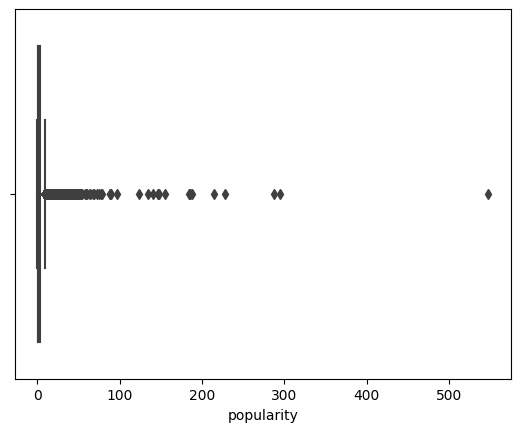

In [27]:
# Popularity
sns.boxplot(data = movies_aux, x = "popularity")

In [28]:
# Todas son películas conocidas y taquilleras, creo que estas popularidades son atípicas pero correctas
movies_aux.loc[movies_aux["popularity"] > 100, (movies_aux.loc[movies_aux["popularity"] > 200]).ne(0).any()]

,id,title,release_year,popularity,vote_average,vote_count,runtime,budget,revenue,genres_Action,...,genres_Fantasy,genres_Romance,pcomp_Warner Bros.,pcomp_Universal Pictures,pcomp_Walt Disney Pictures,pcomp_TriStar Pictures,pcomp_Working Title Films,pcomp_Dune Entertainment,pcountries_United States of America,pcountries_United Kingdom
292,680.0,Pulp Fiction,1994,140.950236,8.3,8670.0,154.0,8000000.0,2.139288e+08,0,...,0,0,0,0,0,0,0,0,1,0
12476,155.0,The Dark Knight,2008,123.167259,8.3,12269.0,152.0,185000000.0,1.004558e+09,1,...,0,0,1,0,0,0,0,0,1,1
14545,19995.0,Avatar,2009,185.070892,7.2,12114.0,162.0,237000000.0,2.787965e+09,1,...,1,0,0,0,0,0,0,1,1,1
23649,210577.0,Gone Girl,2014,154.801009,7.9,6023.0,145.0,61000000.0,3.693304e+08,0,...,0,0,0,0,0,0,0,0,1,0
24323,245891.0,John Wick,2014,183.870374,7.0,5499.0,101.0,20000000.0,8.876166e+07,1,...,0,0,1,0,0,0,0,0,1,0
24427,177572.0,Big Hero 6,2014,213.849907,7.8,6289.0,102.0,165000000.0,6.521054e+08,1,...,0,0,0,0,1,0,0,0,1,0
24844,131631.0,The Hunger Games: Mockingjay - Part 1,2014,147.098006,6.6,5767.0,123.0,125000000.0,7.521002e+08,0,...,0,0,0,0,0,0,0,0,1,0
26531,166426.0,Pirates of the Caribbean: Dead Men Tell No Tales,2017,133.827820,6.6,2814.0,129.0,230000000.0,7.941920e+08,1,...,1,0,0,0,1,0,0,0,1,0
26535,293660.0,Deadpool,2016,187.860492,7.4,11444.0,108.0,58000000.0,7.831130e+08,1,...,0,0,0,0,0,0,0,0,1,0
26537,283995.0,Guardians of the Galaxy Vol. 2,2017,185.330992,7.6,4858.0,137.0,200000000.0,8.634161e+08,1,...,0,0,0,0,1,0,0,0,1,0


In [29]:
# Runtime
# El valor maximo es correcto, corresponde a los 12 cap de la miniserie. Vamos a ver si hay más datos atipicos.
movies_aux.loc[movies_aux["runtime"] == 1256.0, (movies_aux.loc[movies_aux["runtime"] == 1256.0]).ne(0).any()]

,id,title,release_year,popularity,vote_average,vote_count,runtime,genres_Drama,genres_History,pcountries_United States of America
24150,67493.0,Centennial,1978,0.664727,7.9,8.0,1256.0,1,1,1


In [30]:
# Runtime tiene valores NaN, a los desconocidos los ponemos en en la mediana del valor
mediana = np.median(movies_aux["runtime"])
movies_aux["runtime"] = movies_aux["runtime"].fillna(mediana)

<Axes: xlabel='runtime'>

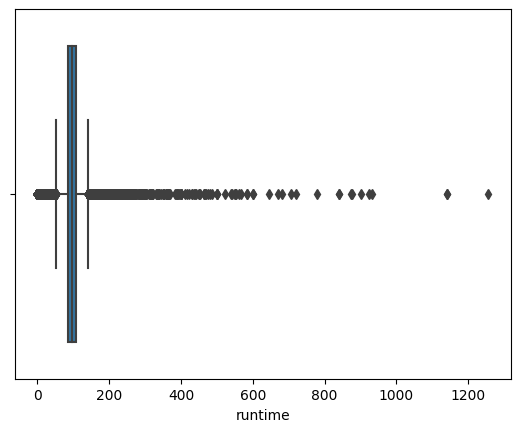

In [31]:
# Aún hay más valores por encima
sns.boxplot(data = movies_aux, x = "runtime")

In [32]:
# Son generalmente miniseries donde se toma el runtime de todos los episodios. Consideramos que los valores son correctos
movies_aux.loc[movies_aux["runtime"] > 800.0]

,id,title,release_year,popularity,vote_average,vote_count,runtime,budget,revenue,genres_Action,...,pcountries_Senegal,pcountries_Qatar,pcountries_Algeria,pcountries_Puerto Rico,pcountries_Malaysia,pcountries_Palestinian Territory,pcountries_Ecuador,pcountries_Burkina Faso,pcountries_Vietnam,pcountries_Bolivia
13762,45560.0,Berlin Alexanderplatz,1980,2.255785,8.4,5.0,931.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
13947,67463.0,Heimat: A Chronicle of Germany,1984,0.016204,9.0,1.0,925.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
19144,208988.0,The War,2007,0.487489,5.3,3.0,874.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
19948,142051.0,Jazz,2001,1.507756,5.7,3.0,1140.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
24150,67493.0,Centennial,1978,0.664727,7.9,8.0,1256.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
26653,150004.0,Taken,2002,10.628230,7.4,76.0,877.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
27825,125336.0,The Story of Film: An Odyssey,2011,1.502510,8.8,26.0,900.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
34624,293603.0,The Roosevelts: An Intimate History,2014,0.824032,8.3,6.0,840.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
34689,38430.0,Seventeen Moments in Spring,1973,0.977018,7.4,10.0,840.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
40876,126820.0,Baseball,1994,0.145073,8.5,4.0,1140.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='vote_average'>

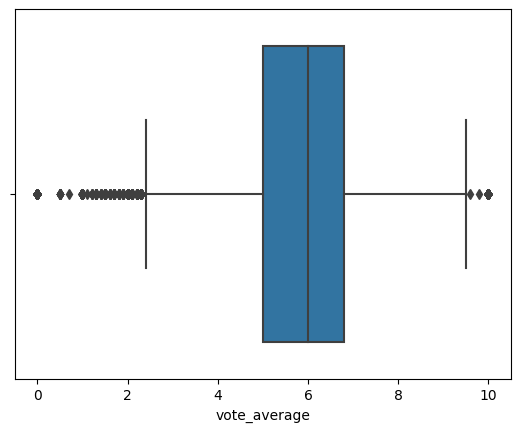

In [33]:
# vote_average
sns.boxplot(data = movies_aux, x = "vote_average")      # Los valores son de 0 a 10, están cargados correctamente

<Axes: xlabel='budget'>

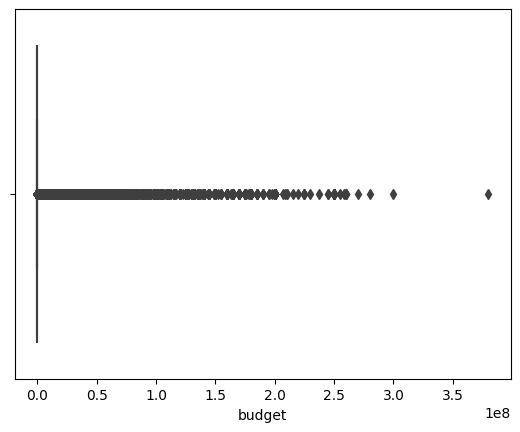

In [34]:
# budget
sns.boxplot(data = movies_aux, x = "budget")        # La inmensa mayoria de las peliculas tienen un bajo presupuesto y hay otras muy por encima

In [35]:
# Las peliculas con un gran presupuesto son valores atipicos pero correctos.
movies_aux.loc[movies_aux["budget"] > 2.5e8, "title"].tolist()

['Superman Returns',
 'Spider-Man 3',
 "Pirates of the Caribbean: At World's End",
 'Tangled',
 'Pirates of the Caribbean: On Stranger Tides',
 'John Carter',
 'The Lone Ranger',
 'Avengers: Age of Ultron',
 'Transformers: The Last Knight']

<Axes: xlabel='revenue'>

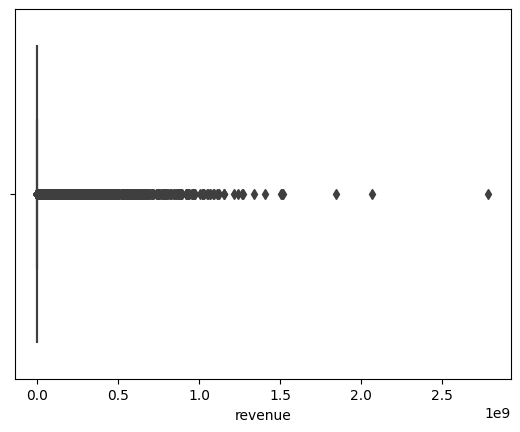

In [36]:
# revenue
sns.boxplot(data = movies_aux, x = "revenue")

In [37]:
# Las peliculas con grandes ganancias son valores atipicos pero correctos.
movies_aux.loc[movies_aux["revenue"] > 1.5e9, "title"]

1637                          Titanic
14545                          Avatar
17807                    The Avengers
25055                  Jurassic World
26526    Star Wars: The Force Awakens
28800                       Furious 7
Name: title, dtype: object

In [52]:
# Hacemos el Standard Scaler
scaler = StandardScaler()
normalizadas = scaler.fit_transform(movies_aux[variables_num])

In [53]:
movies_aux[variables_num] = pd.DataFrame(normalizadas)

In [65]:
# Veo las primeras columnas de una serie de registros y aparentemente se ha hecho bien el Standard Scaler
movies_aux.iloc[:5, :8]

,id,title,release_year,popularity,vote_average,vote_count,runtime,budget
0,862.0,Toy Story,1995,3.165126,1.083828,10.788436,-0.343797,1.477578
1,8844.0,Jumanji,1995,2.344514,0.666152,4.683359,0.256105,3.484560
2,15602.0,Grumpier Old Men,1995,1.462127,0.457314,-0.036789,0.177857,-0.242691
3,31357.0,Waiting to Exhale,1995,0.155279,0.248476,-0.154742,0.856006,0.674786
4,11862.0,Father of the Bride Part II,1995,0.908766,0.039638,0.127938,0.308270,-0.242691


<Axes: >

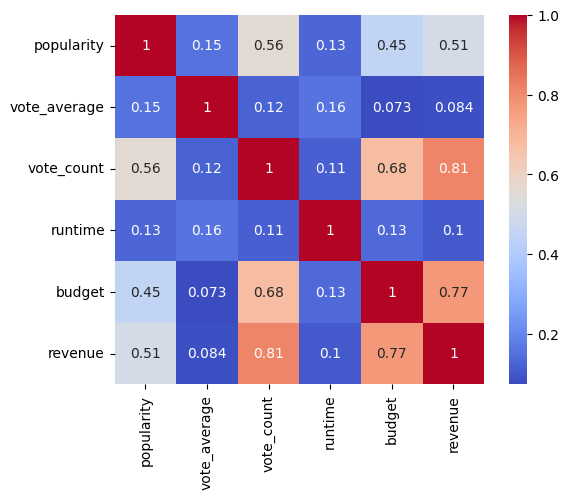

In [38]:
# Hacemos una matriz de correlacion para ver la dependencia entre nuestras variables numericas
correlation_matrix = movies_aux[variables_num].corr()

# Mapa de calor de la matriz de correlacion
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', square = True)

In [39]:
# Los guardamos en csv para ser consumidos por el algoritmo de ML
movies_aux.to_csv('Dataset/movies_ml.csv', index = False)

In [40]:
# Importamos el algoritmo nltk para tokenizar y hacer la lematizacion y tf-id para hacer procesamiento de las overview
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Pruebas de overview
sinopsis = pd.read_csv('Dataset/movies_aux.csv', usecols = ["overview"])["overview"]

In [41]:
# Limpiamos los nan, los hacemos un string vacio
sinopsis = sinopsis.fillna("")
# Creamos una lista a partir de la Series de pandas
sinopsis = sinopsis.tolist()

In [42]:
# Cargamos una lista de 851 stop words en ingles. Fuente: https://countwordsfree.com/stopwords
stop_words = pd.read_json("Dataset\stop_words_english.json")
stop_words = stop_words[0].to_list()

In [43]:
# Tokenización de palabras
tokens = [word_tokenize(text.lower()) for text in sinopsis]      

# Lematización de palabras
lemmatizer = WordNetLemmatizer()
# Usamos las stop words en inglés de la librería
lemmatized_tokens = [[lemmatizer.lemmatize(word) for word in token_list if word not in stop_words] for token_list in tokens]        

# Convertir la lista de tokens lematizados en texto
sinopsis_lemmatized = [' '.join(token_list) for token_list in lemmatized_tokens]

In [44]:
sinopsis_lemmatized

["led woody , andy 's toy live happily room andy 's birthday brings buzz lightyear scene . afraid losing place andy 's heart , woody plot buzz . circumstance separate buzz woody owner , duo eventually learns difference .",
 "sibling judy peter discover enchanted board game open door magical , unwittingly invite alan -- adult 's trapped game 26 year -- living room . alan 's hope freedom finish game , prof risky running giant rhinoceros , evil monkey terrifying creature .",
 "family wedding reignites ancient feud next-door neighbor fishing buddy john max . , sultry italian divorcée open restaurant local bait shop , alarming local worry scare fish . 's interested seafood cooking hot time max .",
 "cheated , mistreated stepped , woman holding breath , waiting elusive `` good man '' break string less-than-stellar lover . friend confidant vannah , bernie , glo robin talk , determined breathe .",
 "george bank recovered daughter 's wedding , receives news 's pregnant ... george 's wife , nina

In [45]:
# Creamos un TfidfVectorizer con un máximo de 100 palabras
vectorizer = TfidfVectorizer(max_features = 100, stop_words = stop_words)

# Transformar y vectorizar el contenido de las sinopsis
vectores_tfidf = vectorizer.fit_transform(sinopsis_lemmatized)

c:\Users\Mauricio Figueroa\.virtualenvs\Python-env--sma9hmZ\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [46]:
# Vocabulario (son palabras únicas) aprendidas por el vectorizer
vocabulario = vectorizer.get_feature_names_out()
vocabulario

array(['american', 'attempt', 'based', 'beautiful', 'big', 'boy',
       'brother', 'child', 'city', 'comedy', 'country', 'couple', 'crime',
       'daughter', 'day', 'dead', 'death', 'decides', 'director',
       'discovers', 'documentary', 'dream', 'drug', 'escape', 'event',
       'face', 'fall', 'family', 'father', 'fight', 'film', 'force',
       'friend', 'gang', 'girl', 'girlfriend', 'good', 'group', 'head',
       'high', 'house', 'human', 'husband', 'job', 'journey', 'kill',
       'killer', 'lead', 'life', 'live', 'living', 'local', 'long',
       'love', 'man', 'meet', 'men', 'money', 'mother', 'movie', 'murder',
       'mysterious', 'named', 'night', 'order', 'parent', 'people',
       'place', 'plan', 'play', 'police', 'power', 'real', 'relationship',
       'return', 'save', 'school', 'secret', 'series', 'set', 'sister',
       'small', 'son', 'star', 'start', 'story', 'student', 'team',
       'time', 'town', 'true', 'turn', 'village', 'war', 'wife', 'woman',
       'wor

In [47]:
# Creo un dataframe de las sinopsis vectorizadas, a un maximo de 100 palabras.
vectores_sinopsis = pd.DataFrame(vectores_tfidf.toarray(), columns = vocabulario)

In [48]:
# Guardo el dataframe de sinopsis
vectores_sinopsis.to_csv('Dataset/vectores_sinopsis.csv', index = False)